# 读取数据

In [3]:
import sys
sys.path.append('../../Utils')

import os 
from data_feed import DataFeed
datafeed = DataFeed(config_path=os.path.join('..', 'config.ini'),
                    local_data_dir='../data')

## HS300期货 - JoinQuant

### 1m

In [4]:
""" 读取本地数据 """
m1_300 = datafeed.load_local_data('IF8888.CCFX', '1m')
print(m1_300.shape)
m1_300.head()

数据加载完成~ 
first_dt:2010-04-16 09:16:00, 
last_dt:2022-01-28 15:00:00
(729960, 8)


,open,close,high,low,volume,money,date,time
0,3474.055,3495.885,3513.114,3474.055,825.0,865458300.0,2010-04-16,09:16:00
1,3495.017,3492.854,3500.204,3491.814,410.0,430079460.0,2010-04-16,09:17:00
2,3492.132,3490.321,3495.163,3487.942,285.0,298402320.0,2010-04-16,09:18:00
3,3489.075,3473.542,3490.248,3473.317,368.0,384303120.0,2010-04-16,09:19:00
4,3473.573,3476.633,3482.627,3471.577,355.0,370525860.0,2010-04-16,09:20:00


## 上证指数 - JoinQuant

### daily

In [5]:
""" 读取本地数据 """
daily_001 = datafeed.load_local_data('000001.XSHG', 'daily')
print(daily_001.shape)
daily_001.head()

数据加载完成~ 
first_dt:2005-01-04 23:59:59, 
last_dt:2022-01-28 23:59:59
(4151, 8)


,open,close,high,low,volume,money,date,time
0,1260.78,1242.77,1260.78,1238.18,816177000.0,4.418452e+09,2005-01-04,23:59:59
1,1241.68,1251.94,1258.58,1235.75,867865100.0,4.916589e+09,2005-01-05,23:59:59
2,1252.49,1239.43,1252.73,1234.24,792225400.0,4.381370e+09,2005-01-06,23:59:59
3,1239.32,1244.75,1256.31,1235.51,894087100.0,5.040042e+09,2005-01-07,23:59:59
4,1243.58,1252.40,1252.72,1236.09,723468300.0,4.118292e+09,2005-01-10,23:59:59


# 函数定义

## 计算指标（ud, cumu_ud, q_buy_cnt, q_sell_cnt）
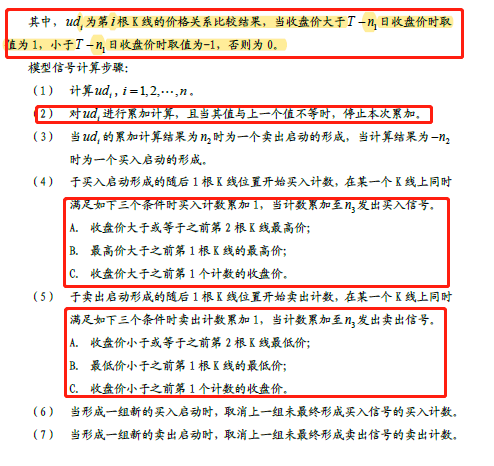

In [6]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import datetime

In [7]:
def calc_ud(mkt_data, n1):    
    close = mkt_data['close']
    """ 计算指标 """
    # 1. ud 
    close_diff_n1 = close - close.shift(n1)
    ud = np.sign(close_diff_n1).fillna(0)
    # 2. cumu_ud
    cumu_ud = np.zeros(shape=ud.shape)
    add_v = 0
    for i, ud_i in enumerate(ud):
        if add_v ==0:
            add_v = ud_i
            cumu_ud[i] = ud_i
        else:            
            if add_v * ud_i < 0: # ud变符号了
                cumu_ud[i] = ud_i
                add_v = ud_i
            else:  # ud没有变符号了
                add_v += ud_i
                cumu_ud[i] = add_v
    """ 赋值 """
    mkt_data['ud'] = ud
    mkt_data['cumu_ud'] = cumu_ud
    return mkt_data  


def calc_q_buysell_cnt(mkt_data):
    close = mkt_data['close']
    high = mkt_data['high']
    low = mkt_data['low']
    """ 计算指标 """
    # 仅对【买入/卖出计数】的前两个条件进行评价。
    #    因为第3个条件涉及【第1个计数收盘价】，在计算signal时才能确定
    q_buy_cnt = ((close>=high.shift(2)) & (high>high.shift(1)))
    q_sell_cnt = ((close<=low.shift(2)) & (low<low.shift(1)))
    """ 赋值 """
    mkt_data['q_buy_cnt'] = q_buy_cnt
    mkt_data['q_sell_cnt'] = q_sell_cnt
    return mkt_data

## 计算信号
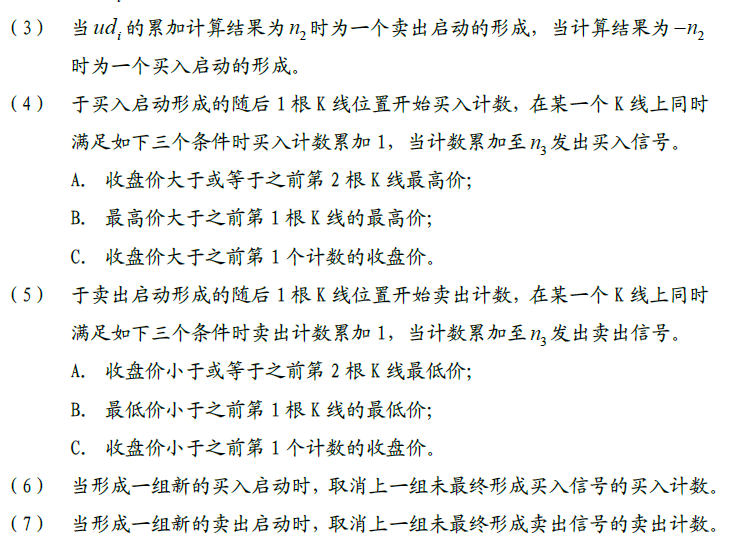

In [8]:
def calc_signal(mkt_data, N2, N3):
    close = mkt_data['close']
    high = mkt_data['high']
    low = mkt_data['low']
    cumu_ud = mkt_data['cumu_ud']        # ud累加结果，为n2时，则形成了【买入/卖出启动】
    q_sell_cnt = mkt_data['q_sell_cnt']  # 是否满足 【买入计数】的前两个条件
    q_buy_cnt = mkt_data['q_buy_cnt']    # 是否满足 【卖出计数】的前两个条件
    
    """ 信号计算 """
    signals = []
    # 【买入计数】 & 【卖出计数】
    buy_cnt_amts, sell_cnt_amts = [], []
    buy_cnt_amt, sell_cnt_amt = None, None 
    # 前1次计数收盘价 
    pre_buy_cnt_c, pre_sell_cnt_c = None, None    
    # 计数周期内最低价/最高价, 用于后边确定止损
    buy_cnt_min_ls, sell_cnt_max_hs = [], []
    buy_cnt_min_l, sell_cnt_max_h = None, None
    
    for v_cumu_ud, q_s, q_b, c, h, l in zip(cumu_ud, q_sell_cnt, q_buy_cnt, close, high, low):
        signal = None
        # 1. 先计算【买入/卖出记数】
        if buy_cnt_amt is not None and buy_cnt_amt<N3:  # 买入计数阶段
            buy_cnt_min_l = min(buy_cnt_min_l, l) if buy_cnt_min_l else l
            if q_b and buy_cnt_amt==0:     # 满足第1次计数条件
                pre_buy_cnt_c = c
                buy_cnt_amt += 1
            elif q_b and c>pre_buy_cnt_c:   # 满足非第1次计数条件
                pre_buy_cnt_c = c
                buy_cnt_amt += 1
        
        if sell_cnt_amt is not None and sell_cnt_amt<N3: # 卖出计数阶段
            sell_cnt_max_h = max(sell_cnt_max_h, h) if sell_cnt_max_h else h        
            if q_s and sell_cnt_amt==0:    # 满足第1次计数条件
                pre_sell_cnt_c = c
                sell_cnt_amt += 1
            elif q_s and c<pre_sell_cnt_c: # 满足非第1次计数条件
                pre_sell_cnt = c
                sell_cnt_amt += 1

        # 2. 后计算是否满足【买入/卖出启动】，因为若满足，则需要初始化【买入/卖出计数】结果
        if v_cumu_ud == -N2:  # 满足【买入启动】，进入【买入计数】阶段，重新初始化
            buy_cnt_amt = 0
            buy_cnt_min_l = None
        elif v_cumu_ud == N2: # 满足【卖出启动】，进入【卖出计数】阶段，重新初始化
            sell_cnt_amt = 0
            sell_cnt_max_h = None

        # 3. 最终信号判断, 发出信号后结束计数阶段
        if buy_cnt_amt==N3:
            signal = 1
            buy_cnt_amt=None
        elif sell_cnt_amt==N3:
            signal = -1
            sell_cnt_amt=None
            
        buy_cnt_amts.append(buy_cnt_amt)
        sell_cnt_amts.append(sell_cnt_amt)
        buy_cnt_min_ls.append(buy_cnt_min_l)
        sell_cnt_max_hs.append(sell_cnt_max_h)        
        signals.append(signal)


    """ 赋值 """
    mkt_data['buy_cnt_amt'] = buy_cnt_amts    # 买入计数
    mkt_data['sell_cnt_amt'] = sell_cnt_amts  # 卖出计数
    mkt_data['buy_cnt_min_l'] = buy_cnt_min_ls   # 买入计数阶段最低价
    mkt_data['sell_cnt_max_h'] = sell_cnt_max_hs # 卖出计数阶段最高价
    mkt_data['signal'] = signals    
    return mkt_data

## 计算止损
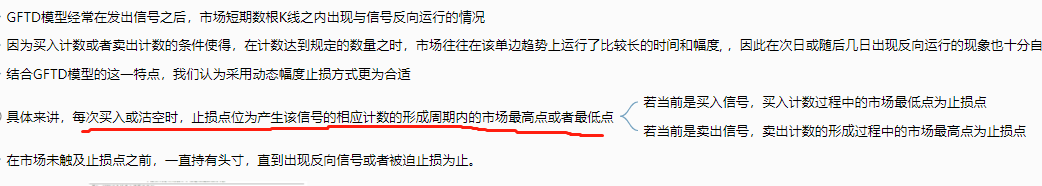

In [9]:
def calc_sl_price(mkt_data):
    """ 
        计算止损价格：
        根据每个有值signal之前一段计数的最高/最低价确定sl_price 
    """
    signal = mkt_data['signal']
    buy_cnt_min_l = mkt_data['buy_cnt_min_l']   # 买入计数阶段最低价
    sell_cnt_max_h = mkt_data['sell_cnt_max_h'] # 卖出计数阶段最高价

    """ 计算 """
    sl_price = buy_cnt_min_l.fillna(0.0)*(signal==1) + sell_cnt_max_h.fillna(0.0)*(signal==-1)
    sl_price[sl_price==0] = None
    sl_price = sl_price.fillna(method='ffill')
    """ 赋值 """ 
    # 当期确定的止损价，下期才能触发
    mkt_data['sl_price'] = sl_price.shift(1)
    return mkt_data

## 计算持仓

In [10]:
def calc_position(mkt_data, shift_period=1, otime_limit=None, etime_limit=None, 
                  is_consider_open=True, is_consider_sl=False, is_daily_close=False,
                  comm = None, leverage=None):
    """  
        params:
            1. shift_period:     偏移周期：
                                    接收到信号后，在T+shift_period期才按信号进行操作。
                                    一般为1，若为0则代表用了未来数据
            2. otime_limit:      最早持仓时间：
                                    针对日内策略。若有值，则会将每天otime_limit及之前的仓位强制设为0
            3. etime_limit:      最晚持仓时间：
                                    针对日内策略。若有值，则会将
            4. is_consider_open: 是否考虑持仓信号到下周期开盘才能操作：
                                    若是，则会将【开仓第一期的hold_in_price & 平仓最后一期的hold_out_price】设为下周期开盘价
            5. is_consider_sl:   是否考虑止损：
                                    需要mkt_data有【sl_price】列，且calc_position函数也要考虑【sl_price】进行生成
            6. is_daily_close:   是否每日关仓：
                                    若是，则每天第一个周期的hold_in_price=open，每天最后一个周期hold_out_price=close
            7. comm:             是否考虑双边佣金：
                                    若为None则不考虑，若为数值则为佣金率，如0.0002代表双边万二手续费率
            8. leverage:         是否考虑杠杆： 
                                    若为None或1则代表不考虑杠杆，若大于1则代表考虑leverage倍的杠杆
    
        利用已经算好的signal, sl_price两列数据及对应参数，计算出以下信息：
            1. is_sl：               是否止损
            2. position：            持仓头寸（在-1到1之间）
            3. hold_in_price：       当周期持仓入成本
            4. hold_out_price：      当周期持仓出成本
            5. open_pos_comm_perc ： 当周期折损买入手续费后比例
            6. close_pos_comm_perc： 当周期折损卖出手续费后比例

        每周期的hold_r公式应为:
            hold_r =  (hold_out_price/hold_in_price) * open_pos_comm_perc * close_pos_comm_perc -1      
    """
    signal = mkt_data['signal']
    sl_price = mkt_data['sl_price']
    position = signal.fillna(method='ffill').shift(shift_period).fillna(0)

    """ A. 是否考虑止损，会根据止损结果重新过滤一遍signal，进而确定position列 """
    if is_consider_sl:        
        """ 1. 计算is_sl：
                - 若持有空仓，sl-h<=0则止损了; 
                - 若持有多仓，l-sl<=0则止损了
        """
        is_sl = (  (-sl_price * np.sign(position))
                 - (mkt_data['high']*(position<0)) 
                 + (mkt_data['low']*(position>0)))<=0
        """ 2. 考虑止损结果生成position """
        #  将止损当期signal设为0（当期signal已为1 or -1，则不变）
        signal_consider_sl = signal.copy()
        signal_consider_sl[(signal_consider_sl.isnull()) & (is_sl)] = 0 
        position = signal_consider_sl.fillna(method='ffill').shift(shift_period).fillna(0)
        """ 3. 空仓期间的is_sl设为False """
        is_sl[position==0] = False
    else:
        is_sl = False
        
    """ B. 是否每天otime前空仓 """
    if otime_limit:
        position[mkt_data['time']<=otime_limit]=0
    
    """ C. 是否每天etime后空仓 """
    if etime_limit:
        position[mkt_data['time']>etime_limit]=0
    
    """ 生成hold_in_price, hold_out_price """
    # 1. 先初始化 period_out_price = close； period_in_price=close.shift(1)
    open_p, close = mkt_data['open'], mkt_data['close']
    hold_in_price =  close.shift(1).copy()
    hold_in_price[close.index[0]] = open_p.values[0]
    hold_out_price = close.copy()

    # 2. 若考虑持仓信号到第二天开盘才能操作
    if is_consider_open:
        # 2-1. 仓位变动第一期的period_in_price为当日open
        hold_in_price[abs(position - position.shift(1).fillna(0))>0] = open_p
        # 2-2. 仓位变动前最后一期的period_out_price为第二日open (除了整个序列最后一天不变)
        hold_out_price[abs(position - position.shift(-1).fillna(0))>0] = open_p.shift(-1)
        hold_out_price[hold_out_price.index[-1]] = close.values[-1]
    
    # 3. 若考虑止损 （mkt_data要先搭配calc_position()函数，计算得到is_sl列）
    if is_consider_sl:
        # 若当期止损了，hold_out_price设为止损价
        #（若多头，止损为open、sl_price里较低的； 若空头，止损为open、sl_price里较高的）
        hold_out_price[is_sl] = (position>0) * np.minimum(open_p, sl_price) + (position<0) * np.maximum(open_p, sl_price)
        #hold_out_price[is_sl] = (position>0) * np.where(open_p>sl_price, sl_price, open_p) + (position<0) * np.where(open_p>sl_price, open_p, sl_price)
        # 若上期止损了，当期hold_in_price设为开盘价
        sl_next_idxes = mkt_data[is_sl].index.values+1
        sl_next_idxes = sl_next_idxes[sl_next_idxes<=mkt_data.index.values[-1]]
        hold_in_price.loc[sl_next_idxes] = open_p
    
    # 4. 是否每日收盘前平仓
    if is_daily_close:
        daily_last_idxes = mkt_data.drop_duplicates(subset='date', keep='last').index
        hold_out_price.loc[daily_last_idxes.values] = close
        daily_first_idxes = mkt_data.drop_duplicates(subset='date', keep='first').index
        hold_out_price.loc[daily_first_idxes.values] = open_p
        
    """ 考虑换仓手续费 """ 
    if comm:
        # 换仓后首期 
        if is_consider_sl: # （有止损：仓位相比上期有变动 或 上期止损，当期仓位不为0）
            is_open_pos = ( (abs(position-position.shift(1))>0)|(is_sl.shift(1)) ) * (abs(position)>0)
        else:              # （无止损：仓位相比上期有变动，            当期仓位不为0）
            is_open_pos = (abs(position-position.shift(1))>0) * (abs(position)>0)
        open_pos_comm_perc = 1/(1+comm * is_open_pos)
        # 换仓前末期
        if is_consider_sl: # （有止损：下期仓位有变动 或 当期止损，当期仓位不为0）
            is_close_pos = ( (abs(position-position.shift(-1))>0)|(is_sl) ) * (abs(position)>0)
        else:             # （无止损：下期仓位有变动             ，当期仓位不为0）
            is_close_pos = (abs(position-position.shift(-1))>0) * (abs(position)>0)
        close_pos_comm_perc = (1-comm * is_close_pos)  
    else:
        open_pos_comm_perc = 1.0
        close_pos_comm_perc = 1.0
    
    """ 考虑杠杆 """
    if leverage:
        position *= leverage
    
    """ 赋值 """
    mkt_data['position'] = position
    mkt_data['is_sl'] = is_sl
    mkt_data['hold_in_price'] = hold_in_price * abs(np.sign(position))
    mkt_data['hold_out_price'] = hold_out_price * abs(np.sign(position))
    mkt_data['open_pos_comm_perc'] = open_pos_comm_perc
    mkt_data['close_pos_comm_perc'] = close_pos_comm_perc
    return mkt_data

## 策略评估

### 统计

In [11]:
def statistic_performance(mkt_data, 
                          r0=0.03, 
                          data_period=1440,
                          is_consider_sl=False):
    """  
        mkt_data：        回测标的的DataFrame，需要已经计算好position列（若is_consider_sl=True，还需要计算好sl_price列）
        r0:               无风险标的年化收益，用于和data_perod一起计算超额收益和夏普率
        data_period：     mkt_data数据的频率，单位为分钟。如1440代表日频数据，1代表1分钟频率数据。
                          用于和r0一起计算超额收益、夏普率
        is_consider_sl:   是否考虑止损，若为True则统计指标中增加【多头止损率、空头止损率】
    """
    position = mkt_data['position']
    hold_in_price = mkt_data['hold_in_price']
    hold_out_price = mkt_data['hold_out_price']
    is_sl = mkt_data['is_sl']
    open_pos_comm_perc = mkt_data['open_pos_comm_perc']
    close_pos_comm_perc = mkt_data['close_pos_comm_perc']
    
    # 计算【回测数据首日】到【回测数据尾日】的长度（换算为年），用于后续计算年化收益、年化夏普等
    d_first = mkt_data['date'].values[0]
    d_last = mkt_data['date'].values[-1]
    d_period = datetime.datetime.strptime(d_last, '%Y-%m-%d') - datetime.datetime.strptime(d_first, '%Y-%m-%d')
    y_period = d_period.days / 365

    """      序列型特征 
        hold_in_price:  周期持仓入价格
        hold_out_price: 周期持仓出价格
        hold_r :        持仓收益
        hold_win :      持仓胜负
        hold_cumu_r :   累计持仓收益
        drawdown :      回撤
        ex_hold_r :     超额收益
    """
    """ 默认配置 
        period_in_price：前一日收盘价
        period_out_price：当日收盘价 
    """
    
    """ 每期的持仓收益hold_r是计算的第一个序列，也是后续统计的核心 
        hold_r = hold_out_price/hold_in_price - 1
    """
    hold_r = position * (hold_out_price/hold_in_price-1)
    # 考虑换仓成本 
    hold_r = open_pos_comm_perc * close_pos_comm_perc * (1+hold_r) - 1
    hold_r.fillna(0.0, inplace=True)
    hold_win = hold_r>0
    hold_cumu_r = (1+hold_r).cumprod() - 1
    drawdown = (hold_cumu_r.cummax()-hold_cumu_r)/(1+hold_cumu_r).cummax()    
    ex_hold_r= hold_r-r0/(250*1440/data_period)
    
    mkt_data['hold_r'] = hold_r
    mkt_data['hold_win'] = hold_win
    mkt_data['hold_cumu_r'] = hold_cumu_r
    mkt_data['drawdown'] = drawdown
    mkt_data['ex_hold_r'] = ex_hold_r
    
    """       数值型特征 
        v_hold_cumu_r：         累计持仓收益
        v_pos_hold_times：      多仓开仓次数
        v_pos_hold_win_times：  多仓开仓盈利次数
        v_pos_hold_period：     多仓持有周期数
        v_pos_hold_win_period： 多仓持有盈利周期数
        v_neg_hold_times：      空仓开仓次数
        v_neg_hold_win_times：  空仓开仓盈利次数
        v_neg_hold_period：     空仓持有盈利周期数
        v_neg_hold_win_period： 空仓开仓次数
        v_pos_sl_times:         多仓止损出局次数
        v_neg_sl_times:         空仓止损出局次数
        
        v_hold_period：         持仓周期数（最后一笔未平仓订单也算）
        v_hold_win_period：     持仓盈利周期数（最后一笔未平仓订单也算）
        
        v_max_dd：              最大回撤
        v_annual_std：          年化标准差
        v_annual_ret：          年化收益
        v_sharpe：              年化夏普
    """
    v_hold_cumu_r = hold_cumu_r.values[-1]

    v_pos_hold_times= 0 
    v_pos_hold_win_times = 0
    v_pos_hold_period = 0
    v_pos_hold_win_period = 0
    v_neg_hold_times= 0 
    v_neg_hold_win_times = 0
    v_neg_hold_period = 0
    v_neg_hold_win_period = 0
    v_pos_sl_times = 0 
    v_neg_sl_times = 0

    for w, r, pre_pos, pos, is_lastp_sl in zip(hold_win, hold_r, position.shift(1), position, is_sl.shift(1)):
        if pre_pos!=pos or is_lastp_sl: # 当周期有换仓 or 上期止损（先结算上次持仓，再初始化本次持仓）
            if pre_pos == pre_pos: # pre_pos非空（为空则是循环第一次，无需结算）
                # 结算上一次持仓
                if pre_pos>0: # 多仓
                    v_pos_hold_times += 1
                    v_pos_hold_period += tmp_hold_period
                    v_pos_hold_win_period += tmp_hold_win_period
                    if tmp_hold_r>0:
                        v_pos_hold_win_times+=1
                    if is_lastp_sl:
                        v_pos_sl_times += 1
                elif pre_pos<0: # 空仓
                    v_neg_hold_times += 1      
                    v_neg_hold_period += tmp_hold_period
                    v_neg_hold_win_period += tmp_hold_win_period
                    if tmp_hold_r>0:                    
                        v_neg_hold_win_times+=1
                    if is_lastp_sl:
                        v_neg_sl_times += 1
            # 初始化持仓（每次关仓结算后，或循环第一次时）
            tmp_hold_r = 0
            tmp_hold_period = 0 
            tmp_hold_win_period = 0
        if abs(pos)>0:
            tmp_hold_period += 1
            if r>0:
                tmp_hold_win_period += 1
            if abs(r)>0:
                tmp_hold_r = (1+tmp_hold_r)*(1+r)-1       

    v_hold_period = (abs(position)>0).sum()
    v_hold_win_period = (hold_r>0).sum()
    v_max_dd = drawdown.max()
    
    v_annual_ret = (1+v_hold_cumu_r) ** (1/y_period) - 1
    v_annual_std = ex_hold_r.std() * np.sqrt( len(mkt_data)/y_period ) 
    v_sharpe= v_annual_ret / v_annual_std

    """ 生成Performance DataFrame """
    if is_consider_sl:
        performance_cols = ['累计收益', 
                            '多仓次数', '多仓成功次数', '多仓胜率', '多仓平均持有期',
                                        '多仓止损次数', '多仓止损率',
                            '空仓次数', '空仓成功次数',  '空仓胜率', '空仓平均持有期', 
                                        '空仓止损次数', '空仓止损率',
                            '周期胜率', '最大回撤', '年化收益/最大回撤',
                            '年化收益', '年化标准差', '年化夏普'
                           ]
        performance_values = ['{:.2%}'.format(v_hold_cumu_r),
                              v_pos_hold_times, v_pos_hold_win_times,
                                                '{:.2%}'.format(v_pos_hold_win_times/v_pos_hold_times), 
                                                '{:.2f}'.format(v_pos_hold_period/v_pos_hold_times),
                              v_pos_sl_times,   '{:.2%}'.format(v_pos_sl_times/v_pos_hold_times),
                              v_neg_hold_times, v_neg_hold_win_times,
                                                '{:.2%}'.format(v_neg_hold_win_times/v_neg_hold_times), 
                                                '{:.2f}'.format(v_neg_hold_period/v_neg_hold_times),
                              v_neg_sl_times,   '{:.2%}'.format(v_neg_sl_times/v_neg_hold_times),
                              '{:.2%}'.format(v_hold_win_period/v_hold_period), 
                              '{:.2%}'.format(v_max_dd), 
                              '{:.2f}'.format(v_annual_ret/v_max_dd),
                              '{:.2%}'.format(v_annual_ret), 
                              '{:.2%}'.format(v_annual_std), 
                              '{:.2f}'.format(v_sharpe)
                             ]
    else:
        performance_cols = ['累计收益', 
                            '多仓次数', '多仓成功次数', '多仓胜率', '多仓平均持有期', 
                            '空仓次数', '空仓成功次数',  '空仓胜率', '空仓平均持有期', 
                            '周期胜率', '最大回撤', '年化收益/最大回撤',
                            '年化收益', '年化标准差', '年化夏普'
                           ]
        performance_values = ['{:.2%}'.format(v_hold_cumu_r),
                              v_pos_hold_times, v_pos_hold_win_times,
                                                '{:.2%}'.format(v_pos_hold_win_times/v_pos_hold_times), 
                                                '{:.2f}'.format(v_pos_hold_period/v_pos_hold_times),
                              v_neg_hold_times, v_neg_hold_win_times,
                                                '{:.2%}'.format(v_neg_hold_win_times/v_neg_hold_times), 
                                                '{:.2f}'.format(v_neg_hold_period/v_neg_hold_times),
                              '{:.2%}'.format(v_hold_win_period/v_hold_period), 
                              '{:.2%}'.format(v_max_dd), 
                              '{:.2f}'.format(v_annual_ret/v_max_dd),
                              '{:.2%}'.format(v_annual_ret), 
                              '{:.2%}'.format(v_annual_std), 
                              '{:.2f}'.format(v_sharpe)
                             ]
    performance_df = pd.DataFrame(performance_values, index=performance_cols)
    
    return mkt_data, performance_df

### 可视化

#### 整体评估

In [12]:
import datetime
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import column, row, gridplot, layout
from bokeh.models import Span

output_notebook()

Loading BokehJS ...

In [13]:
def visualize_performance(mkt_data):
    if 'trade_date' in mkt_data:
        mkt_data['trade_datetime'] = mkt_data['trade_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y%m%d'))
        dt = mkt_data['trade_datetime']
    else:
        dt = [datetime.datetime.strptime('{} {}'.format(d, t), '%Y-%m-%d %H:%M:%S') 
              for d, t in zip(mkt_data['date'], mkt_data['time'])]

    f1 = figure(height=300, width=700, sizing_mode='stretch_width', 
                title='Target Trend',
                x_axis_type='datetime',
                x_axis_label="trade_datetime", y_axis_label="close")
    f2 = figure(height=200, sizing_mode='stretch_width', 
                title='Position',
                x_axis_label="trade_datetime", y_axis_label="position",
                x_axis_type='datetime',
                x_range=f1.x_range)
    f3 = figure(height=200, sizing_mode='stretch_width', 
                title='Return',
                x_axis_type='datetime',
                x_range=f1.x_range)
    f4 = figure(height=200, sizing_mode='stretch_width', 
                title='Drawdown',
                x_axis_type='datetime',
                x_range=f1.x_range)


    # 绘制行情
    close = mkt_data['close']
    cumu_hold_close = (mkt_data['hold_cumu_r']+1) * close.tolist()[0]
    f1.line(dt, close, line_width=1)
    f1.line(dt, cumu_hold_close, line_width=1, color='red')

    # 绘制指标
    indi = figure(height=200, sizing_mode='stretch_width', 
                  title='KDJ',
                  x_axis_type='datetime',
                  x_range=f1.x_range
                 )


    # 绘制仓位
    position = mkt_data['position']
    f2.step(dt, position)

    # 绘制收益
    hold_r = mkt_data['hold_r']
    f3.vbar(x=dt, top=hold_r)

    # 绘制回撤
    drawdown = mkt_data['drawdown']
    f4.line(dt, -drawdown, line_width=1)

    #p = column(f1,f2,f3,f4)
    p = gridplot([ [f1],
                   #[indi],
                   [f2], 
                   [f3],
                   [f4]
                 ])
    show(p)

#### By Day

In [59]:
#### Interactivity -- BOKEH

#from bokeh.plotting import figure, show, output_notebook
import bokeh.plotting.figure as bk_figure
from bokeh.io import curdoc, show
from bokeh.layouts import column, row, gridplot, layout, widgetbox
from bokeh.models.widgets import Slider, TextInput
#from bokeh.models.tickers import FixedTicker

from bokeh.models import ColumnDataSource, HoverTool
#from bokeh.models import Arrow, NormalHead, OpenHead, VeeHead
#from bokeh.models import Span
from bokeh.models import PolyAnnotation, DatePicker
#from bokeh.models import CustomJS

from bokeh.io import output_notebook # enables plot interface in J notebook
import numpy as np

# init bokeh
from bokeh.application import Application
from bokeh.application.handlers import FunctionHandler

""" 
    我的Jupyter Notebook改过启动端口，不是默认的8888，而是888，
    所以我得设置下临时变量：BOKEH_ALLOW_WS_ORIGIN，否则会报错
"""
import os 
os.environ['BOKEH_ALLOW_WS_ORIGIN'] = 'localhost:888'

import yaml
from bokeh.themes.theme import Theme

output_notebook()

############ END BOILERPLATE ############

Loading BokehJS ...

In [15]:
def visualize_res_mkt_data_by_day(mkt_data, is_consider_sl=False, default_date=None,
                                  begin_date=None, end_date=None):
    mkt_data['dt'] = ['{} {}'.format(d, t) for d, t in zip(mkt_data['date'], mkt_data['time'])]
    dates = sorted(mkt_data['date'].unique())
    min_date, max_date = dates[0], dates[-1]
    print(min_date, max_date)
    if not default_date:
         default_date = min_date
    def generate_daily_plot_panel(doc):
        """  
            主要用来展示某天的数据，包括以下四部分：
                1. Candle Bar
                2. Signal Arrow
                3. SL Price Line
                4. Position Background    
        """
        # 1. Load Data & generate Source
        data = mkt_data[mkt_data['date']==default_date]
        if begin_date and end_date:
            data = mkt_data[(mkt_data['date']>=begin_date)&(mkt_data['date']<=end_date)]
            
        source = ColumnDataSource(data)
        inc_source = ColumnDataSource(data.loc[data.close >= data.open])
        dec_source = ColumnDataSource(data.loc[data.open > data.close])    
        buy_signal_source = ColumnDataSource(data.loc[data.signal==1])
        sell_signal_source = ColumnDataSource(data.loc[data.signal==-1])    
        pos_pos_source = ColumnDataSource(data.loc[data.position>0])
        neg_pos_source = ColumnDataSource(data.loc[data.position<0])     
            
        # 2. Draw the Plot
        def generate_plot():
            p1 = figure(plot_height=400, plot_width=800, 
                       tools='pan, wheel_zoom, box_zoom, reset, crosshair',
                       toolbar_location='above')   
            p2 = figure(plot_height=100, plot_width=800, x_range=p1.x_range)

            # 2-1. Candle Bar
            p1.segment(x0='index', y0='high', x1='index', y1='low', color='orange', source=inc_source)
            p1.segment(x0='index', y0='high', x1='index', y1='low', color='green', source=dec_source)
            p1.vbar('index', 0.5, 'open', 'close', fill_color='white', line_color='orange', source=inc_source, hover_fill_alpha=0.5)
            p1.vbar('index', 0.5, 'open', 'close', fill_color='white', line_color='green', source=dec_source, hover_fill_alpha=0.5)
            # 2-2. SL_Price Line
            p1.line('index', 'sl_price', color='purple', source=source)

            # 2-3. Signal Arrow
            p1.circle(x='index', y='low', radius=0.3, color='red', fill_alpha=0.1,source=buy_signal_source)
            p1.circle(x='index', y='high', radius=0.3, color='blue', fill_alpha=0.1, source=sell_signal_source)
            #p1.add_layout(Arrow(end=OpenHead(line_color="firebrick", line_width=4), x_start=0, y_start=0, x_end=1, y_end=0))

            # 2-4. Position Bakcground        
            p2.vbar('index', 1, 0, 1, fill_color='red', line_color='red', source=pos_pos_source, hover_fill_alpha=0.5)
            p2.vbar('index', 1, 0, -1, fill_color='green', line_color='green', source=neg_pos_source, hover_fill_alpha=0.5)

            # 3. Modify Axis Label
            p1.xaxis.axis_label = 'datetime'
            p1.yaxis.axis_label = 'price'
            #p.xaxis.major_label_overrides = {int(idx): dt for idx, dt in zip(source.data['index'], source.data['dt'])}
            #p.xaxis.major_label_orientation = np.pi/4
            p2.xaxis.axis_label="datetime"
            p2.yaxis.axis_label="position"
            p2.yaxis.bounds=(-1, 1)
            
            # 4. Add Hover Tool
            tooltips = [('date', '@date'),
                        ('time', '@time'),
                        ('open', '@{open}{0.2f}'),
                        ('high', '@{high}{0.2f}'),
                        ('low', '@{low}{0.2f}'),
                        ('close', '@{close}{0.2f}'),
                        ('hold_in_price', '@{hold_in_price}{0.2f}'), 
                        ('hold_out_price', '@{hold_out_price}{0.2f}'), 
                        ('open_pos_comm_perc', '@{open_pos_comm_perc}{%0.2f}'),
                        ('open_pos_comm_perc', '@{open_pos_comm_perc}{%0.2f}'),
                        ('hold_r', '@{hold_r}{%0.2f}'), 
                       ]
            if is_consider_sl:
                tooltips.extend([('sl_price', '@{sl_price}{0.2f}'),
                                 ('is_sl', '@{is_sl}'), ])
            hover = HoverTool(tooltips=tooltips,
                              mode='vline'
                              )
            p1.add_tools(hover)
            
            p = column(p1, p2)
            return p

        def date_picker_onChange(attr, old, new):
            data = mkt_data[mkt_data['date']==new]
            # Update Source
            source.data = ColumnDataSource.from_df(data)
            inc_source.data = ColumnDataSource.from_df(data.loc[data.close >= data.open])
            dec_source.data = ColumnDataSource.from_df(data.loc[data.open > data.close])    
            buy_signal_source.data = ColumnDataSource.from_df(data.loc[data.signal==1])
            sell_signal_source.data = ColumnDataSource.from_df(data.loc[data.signal==-1])    
            pos_pos_source.data = ColumnDataSource.from_df(data.loc[data.position>0])
            neg_pos_source.data = ColumnDataSource.from_df(data.loc[data.position<0])

        def generate_widget():
            date_picker = DatePicker(title="Date Selection", value=default_date, min_date=min_date, max_date=max_date)
            date_picker.on_change('value', date_picker_onChange)
            widget_box = widgetbox(date_picker)  
            return widget_box

        plot = generate_plot()
        widget = generate_widget()

        doc.add_root(column(widget, plot))
        doc.theme = Theme(json=yaml.load("""
            attrs:
                Figure:
                    background_fill_color: "white"
                    outline_line_color: white
                    toolbar_location: above
                    height: 400
                    width: 600
                Grid:
                    grid_line_dash: [6, 4]
                    grid_line_color: white
        """, Loader=yaml.FullLoader))
    show(generate_daily_plot_panel)

#### By Year & Position

In [16]:
#(res_m1_300[res_m1_300['position']>0]['hold_r']+1).cumprod().plot()
#(res_m1_300[res_m1_300['position']<0]['hold_r']+1).cumprod().plot()

# 整体运行

In [19]:
import warnings
warnings.filterwarnings("ignore")

## 上证指数 - daily

### 信号实例

In [72]:
daily_001 = calc_ud(daily_001, n1=4)
daily_001 = calc_q_buysell_cnt(daily_001)
daily_001 = calc_signal(daily_001, N2=6, N3=4)
daily_001 = calc_sl_price(daily_001)
daily_001 = calc_position(daily_001, shift_period=1, otime_limit=None, etime_limit=None, 
                           is_consider_open=True, is_consider_sl=False, is_daily_close=False,
                           comm=0.0002, 
                           leverage=None)

print(daily_001['signal'].value_counts())
daily_001.head()

-1.0    69
 1.0    66
Name: signal, dtype: int64


,open,close,high,low,volume,money,date,time,ud,cumu_ud,...,buy_cnt_min_l,sell_cnt_max_h,signal,sl_price,position,is_sl,hold_in_price,hold_out_price,open_pos_comm_perc,close_pos_comm_perc
0,1260.78,1242.77,1260.78,1238.18,816177000.0,4.418452e+09,2005-01-04,23:59:59,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,False,0.0,0.0,1.0,1.0
1,1241.68,1251.94,1258.58,1235.75,867865100.0,4.916589e+09,2005-01-05,23:59:59,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,False,0.0,0.0,1.0,1.0
2,1252.49,1239.43,1252.73,1234.24,792225400.0,4.381370e+09,2005-01-06,23:59:59,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,False,0.0,0.0,1.0,1.0
3,1239.32,1244.75,1256.31,1235.51,894087100.0,5.040042e+09,2005-01-07,23:59:59,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,False,0.0,0.0,1.0,1.0
4,1243.58,1252.40,1252.72,1236.09,723468300.0,4.118292e+09,2005-01-10,23:59:59,1.0,1.0,...,NaN,NaN,NaN,NaN,0.0,False,0.0,0.0,1.0,1.0


In [17]:
""" 2011Q4以来4次信号 """
visualize_res_mkt_data_by_day(daily_001, begin_date='2011-11-01', end_date='2012-07-10')

2005-01-04 2022-01-28


In [18]:
""" 信号实例 2012.05.09 & 2012.03.17 """
visualize_res_mkt_data_by_day(daily_001, begin_date='2012-01-01', end_date='2012-05-10')

2005-01-04 2022-01-28


In [19]:
show_cols = ['date', 'time', 'close', 
             'ud', 'cumu_ud', 'q_buy_cnt', 'q_sell_cnt',
             'buy_cnt_min_l', 'sell_cnt_max_h',
             'buy_cnt_amt', 'sell_cnt_amt', 'signal']
daily_001[ (daily_001['date']>='2012-03-15') & (daily_001['date']<='2012-04-15')][show_cols]

,date,time,close,ud,cumu_ud,q_buy_cnt,q_sell_cnt,buy_cnt_min_l,sell_cnt_max_h,buy_cnt_amt,sell_cnt_amt,signal
1747,2012-03-15,23:59:59,2373.77,-1.0,-2.0,False,True,2132.63,2478.38,NaN,NaN,NaN
1748,2012-03-16,23:59:59,2404.74,-1.0,-3.0,False,False,2132.63,2478.38,NaN,NaN,NaN
1749,2012-03-19,23:59:59,2410.18,-1.0,-4.0,True,False,2132.63,2478.38,NaN,NaN,NaN
1750,2012-03-20,23:59:59,2376.84,-1.0,-5.0,False,False,2132.63,2478.38,NaN,NaN,NaN
1751,2012-03-21,23:59:59,2378.20,1.0,1.0,False,True,2132.63,2478.38,NaN,NaN,NaN
1752,2012-03-22,23:59:59,2375.77,-1.0,-1.0,False,False,2132.63,2478.38,NaN,NaN,NaN
1753,2012-03-23,23:59:59,2349.54,-1.0,-2.0,False,True,2132.63,2478.38,NaN,NaN,NaN
1754,2012-03-26,23:59:59,2350.60,-1.0,-3.0,False,True,2132.63,2478.38,NaN,NaN,NaN
1755,2012-03-27,23:59:59,2347.18,-1.0,-4.0,False,False,2132.63,2478.38,NaN,NaN,NaN
1756,2012-03-28,23:59:59,2284.88,-1.0,-5.0,False,True,2132.63,2478.38,NaN,NaN,NaN


In [20]:
""" 信号实例： 新的买入启动重置盖前信号 """
visualize_res_mkt_data_by_day(daily_001, begin_date='2011-07-10', end_date='2011-09-30')

2005-01-04 2022-01-28


In [21]:
show_cols = ['date', 'time', 'close', 
             'ud', 'cumu_ud', 'q_buy_cnt', 'q_sell_cnt', 
             'buy_cnt_min_l', 'sell_cnt_max_h',
             'buy_cnt_amt', 'sell_cnt_amt', 'signal']
daily_001[ (daily_001['date']>='2011-08-05') & (daily_001['date']<='2011-09-10')][show_cols]

,date,time,close,ud,cumu_ud,q_buy_cnt,q_sell_cnt,buy_cnt_min_l,sell_cnt_max_h,buy_cnt_amt,sell_cnt_amt,signal
1601,2011-08-05,23:59:59,2626.42,-1.0,-4.0,False,True,2605.14,2826.96,0.0,NaN,NaN
1602,2011-08-08,23:59:59,2526.82,-1.0,-5.0,False,True,2497.92,2826.96,0.0,NaN,NaN
1603,2011-08-09,23:59:59,2526.07,-1.0,-6.0,False,True,NaN,2826.96,0.0,NaN,NaN
1604,2011-08-10,23:59:59,2549.18,-1.0,-7.0,False,False,2544.95,2826.96,0.0,NaN,NaN
1605,2011-08-11,23:59:59,2581.51,-1.0,-8.0,True,False,2505.01,2826.96,1.0,NaN,NaN
1606,2011-08-12,23:59:59,2593.17,1.0,1.0,True,False,2505.01,2826.96,2.0,NaN,NaN
1607,2011-08-15,23:59:59,2626.77,1.0,2.0,True,False,2505.01,2826.96,3.0,NaN,NaN
1608,2011-08-16,23:59:59,2608.17,1.0,3.0,True,False,2505.01,2826.96,3.0,NaN,NaN
1609,2011-08-17,23:59:59,2601.26,1.0,4.0,False,False,2505.01,2826.96,3.0,NaN,NaN
1610,2011-08-18,23:59:59,2559.47,-1.0,-1.0,False,True,2505.01,2826.96,3.0,NaN,NaN


### 回测表现-不带止损策略

In [80]:
""" 持仓计算 """
daily_001 = calc_position(daily_001, shift_period=1, otime_limit=None, etime_limit=None, 
                           is_consider_open=True, is_consider_sl=False, is_daily_close=False,
                           comm=0.0002, 
                           leverage=None)

""" 策略评估 """
res_daily_001, performance_df = statistic_performance(daily_001,
                                                   r0=0.03, 
                                                   data_period=1440,
                                                   is_consider_sl=False, 
                                                  )

print(performance_df)
#visualize_performance(res_daily_001)

                 0
累计收益       722.92%
多仓次数            51
多仓成功次数          24
多仓胜率        47.06%
多仓平均持有期      41.35
空仓次数            51
空仓成功次数          21
空仓胜率        41.18%
空仓平均持有期      38.78
周期胜率        53.11%
最大回撤        71.08%
年化收益/最大回撤     0.18
年化收益        13.14%
年化标准差       24.41%
年化夏普          0.54


### 回测表现-带止损

In [79]:
""" 持仓计算 """
daily_001 = calc_position(daily_001, shift_period=1, otime_limit=None, etime_limit=None, 
                           is_consider_open=True, is_consider_sl=True, is_daily_close=False,
                           comm=0.0002, 
                           leverage=None)

""" 策略评估 """
res_daily_001, performance_df = statistic_performance( daily_001,
                                                       r0=0.03, 
                                                       data_period=1440,
                                                       is_consider_sl=True, 
                                                      )

print(performance_df)
#visualize_performance(res_daily_001)

                 0
累计收益       667.78%
多仓次数            56
多仓成功次数          26
多仓胜率        46.43%
多仓平均持有期      35.09
多仓止损次数          14
多仓止损率       25.00%
空仓次数            59
空仓成功次数          22
空仓胜率        37.29%
空仓平均持有期      29.02
空仓止损次数          14
空仓止损率       23.73%
周期胜率        53.57%
最大回撤        66.65%
年化收益/最大回撤     0.19
年化收益        12.68%
年化标准差       23.23%
年化夏普          0.55


## 沪深300 - 1m

### 参数调优-带止损

In [99]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt 
sns.set()
from tqdm import tqdm

def calc_cumu_hold_nv_and_position( mkt_data, 
                                    #f_calc_indi,     params_calc_indi, 
                                    f_calc_signal,   params_calc_signal,
                                    f_calc_sl_price, params_calc_sl_price,
                                    f_calc_pos,      params_calc_pos,
                                    f_stat_perf,     params_stat_perf,
                                   ):
    """ 依次进行【指标计算、信号计算、止损价计算、持仓计算、表现评估】"""
    mkt_data = f_calc_signal(mkt_data, params_calc_signal['N2'], params_calc_signal['N3'])    
    
    if f_calc_sl_price is not None:
        mkt_data = f_calc_sl_price(mkt_data)

    mkt_data = f_calc_pos(mkt_data, 
                          shift_period=params_calc_pos['shift_period'], 
                          otime_limit=params_calc_pos['otime_limit'], 
                          etime_limit=params_calc_pos['etime_limit'], 
                          is_consider_sl=params_calc_pos['is_consider_sl'],
                          is_daily_close=params_calc_pos['is_daily_close'],
                          comm=params_calc_pos['comm'])
    
    res_mkt_data, perf_df = f_stat_perf(mkt_data, 
                                        data_period=params_stat_perf['data_period'],
                                        is_consider_sl=params_stat_perf['is_consider_sl']
                                       )
    return res_mkt_data, perf_df

In [100]:
""" 
    生成调优参数范围：
        N1 (1~10) 
        N2 (1~10)
        N3~(1~10)
"""        

n1_min, n1_max, n1_dist = 1, 10, 1
n2_min, n2_max, n2_dist = 1, 10, 1
n3_min, n3_max, n3_dist = 1, 10, 1

params = []
for i, n1 in enumerate(range(n1_min, n1_max+1, n1_dist)):
    for j, n2 in enumerate(range(n2_min, n2_max+1, n2_dist)):
        for k, n3 in enumerate(range(n3_min, n3_max+1, n3_dist)):
            params.append((n1, n2, n3))            

""" 选定回测数据范围 """
bt_data = m1_300[m1_300['date']<='2011-12-31'].copy()

""" 开始滚动计算 """
# 1. q_buy_cne, q_sell_cnt只需计算一次
bt_data = calc_q_buysell_cnt(bt_data)

# 2. ud对不同n1才不一样, 提前算好存到一个dict里
bt_data_with_indi_dict = {n1: calc_ud(bt_data, n1=n1).copy()  
                          for n1 in range(n1_min, n1_max+1, n1_dist)}
# 3. 滚动起来
res_dfs = []
for p in tqdm(params):
    n1, n2, n3 = p[0], p[1], p[2]
    """ 样本期内评估表现 """
    bt_data_with_indi = bt_data_with_indi_dict[n1]
    _, perf_df = calc_cumu_hold_nv_and_position(bt_data_with_indi,
                                                calc_signal,    {'N2': n2, 'N3': n3},
                                                calc_sl_price,  None,
                                                calc_position,  {'shift_period': 1, 
                                                                 'otime_limit': None, 
                                                                 #'etime_limit': None, 'is_daily_close': False,
                                                                 'etime_limit': '15:00:00', 'is_daily_close': True,
                                                                 'is_consider_sl': True,
                                                                 'comm': 0.0002},
                                                statistic_performance, {'data_period': 1,
                                                                        'is_consider_sl': True ,
                                                                        },
                                               )
    """ 记录【累计收益/最大回撤】 """
    annual_r_divide_max_dd = float(perf_df.values[16][0].strip('%'))/float(perf_df.values[14][0].strip('%'))
    cumu_r = float(perf_df.values[0][0].strip('%'))/100
    res_dfs.append([n1, n2, n3, annual_r_divide_max_dd, cumu_r])

res_df = pd.DataFrame(res_dfs, columns=['N1', 'N2', 'N3', 'annual_ret/max_dd', 'cumu_r'])

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:14<00:00,  2.30it/s]


In [101]:
print(res_df.sort_values('cumu_r', ascending=False).head(10).mean())
res_df.sort_values('cumu_r', ascending=False).head(10)

N1                   6.200000
N2                   6.800000
N3                   8.700000
annual_ret/max_dd    9.107468
cumu_r               1.709410
dtype: float64


,N1,N2,N3,annual_ret/max_dd,cumu_r
688,7,9,9,9.217687,1.7610
314,4,2,5,10.490298,1.7555
697,7,10,8,10.543194,1.7415
679,7,8,10,9.301050,1.7197
538,6,4,9,8.437700,1.7072
359,4,6,10,10.253906,1.6948
798,8,10,9,8.895810,1.6899
358,4,6,9,9.177986,1.6853
788,8,9,9,7.937755,1.6703
638,7,4,9,6.819298,1.6689


In [102]:
print(res_df.sort_values('annual_ret/max_dd', ascending=False).head(10).mean())
res_df.sort_values('annual_ret/max_dd', ascending=False).head(10)

N1                    4.600000
N2                    4.900000
N3                    7.900000
annual_ret/max_dd    10.586778
cumu_r                1.582550
dtype: float64


,N1,N2,N3,annual_ret/max_dd,cumu_r
28,1,3,9,11.283721,1.5432
469,5,7,10,11.172363,1.6040
526,6,3,7,11.161388,1.5737
515,6,2,6,11.011551,1.3929
697,7,10,8,10.543194,1.7415
314,4,2,5,10.490298,1.7555
359,4,6,10,10.253906,1.6948
348,4,5,9,10.072633,1.6670
315,4,2,6,9.992806,1.4600
488,5,9,9,9.885926,1.3929


### 回测表现-不带止损

In [88]:
""" 计算指标、信号、持仓 """
m1_300 = calc_ud(m1_300, n1=6)
m1_300 = calc_q_buysell_cnt(m1_300)
m1_300 = calc_signal(m1_300, N2=6, N3=9)
m1_300 = calc_sl_price(m1_300)
m1_300 = calc_position(m1_300, shift_period=1, otime_limit=None, 
                       #etime_limit='15:00:00', is_daily_close=True,
                       is_consider_open=True, is_consider_sl=False, 
                       comm=0.0002, 
                       leverage=None)

print(m1_300[m1_300['date']<='2012-07-06']['signal'].value_counts())
m1_300.head()

-1.0    1283
 1.0     625
Name: signal, dtype: int64


,open,close,high,low,volume,money,date,time,ud,cumu_ud,...,buy_cnt_min_l,sell_cnt_max_h,signal,sl_price,position,is_sl,hold_in_price,hold_out_price,open_pos_comm_perc,close_pos_comm_perc
0,3474.055,3495.885,3513.114,3474.055,825.0,865458300.0,2010-04-16,09:16:00,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,False,0.0,0.0,1.0,1.0
1,3495.017,3492.854,3500.204,3491.814,410.0,430079460.0,2010-04-16,09:17:00,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,False,0.0,0.0,1.0,1.0
2,3492.132,3490.321,3495.163,3487.942,285.0,298402320.0,2010-04-16,09:18:00,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,False,0.0,0.0,1.0,1.0
3,3489.075,3473.542,3490.248,3473.317,368.0,384303120.0,2010-04-16,09:19:00,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,False,0.0,0.0,1.0,1.0
4,3473.573,3476.633,3482.627,3471.577,355.0,370525860.0,2010-04-16,09:20:00,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,False,0.0,0.0,1.0,1.0


In [91]:
""" 策略评估 """
res_m1_300, performance_df = statistic_performance(m1_300[m1_300['date']<='2012-07-06'],
                                                   #m1_300[m1_300['date']>'2012-07-06'],
                                                   r0=0.03, 
                                                   data_period=1, 
                                                   is_consider_sl=False, 
                                                  )

print(performance_df)
#visualize_performance(res_m1_300)

                 0
累计收益       178.14%
多仓次数           450
多仓成功次数         182
多仓胜率        40.44%
多仓平均持有期     100.70
空仓次数           451
空仓成功次数         180
空仓胜率        39.91%
空仓平均持有期     222.42
周期胜率        50.64%
最大回撤        14.69%
年化收益/最大回撤     3.97
年化收益        58.38%
年化标准差       20.11%
年化夏普          2.90


### 回测表现-带止损

In [92]:
""" 计算指标、信号、持仓 """
m1_300 = calc_ud(m1_300, n1=6)
m1_300 = calc_q_buysell_cnt(m1_300)
m1_300 = calc_signal(m1_300, N2=6, N3=9)
m1_300 = calc_sl_price(m1_300)
m1_300 = calc_position(m1_300, shift_period=1, otime_limit=None, 
                       #etime_limit='15:00:00', is_daily_close=True, 
                       is_consider_open=True, is_consider_sl=True, 
                       comm=0.0002, 
                       leverage=None)

print(m1_300[m1_300['date']<='2012-07-06']['signal'].value_counts())
m1_300.head()

-1.0    1283
 1.0     625
Name: signal, dtype: int64


,open,close,high,low,volume,money,date,time,ud,cumu_ud,...,buy_cnt_min_l,sell_cnt_max_h,signal,sl_price,position,is_sl,hold_in_price,hold_out_price,open_pos_comm_perc,close_pos_comm_perc
0,3474.055,3495.885,3513.114,3474.055,825.0,865458300.0,2010-04-16,09:16:00,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,False,0.0,0.0,1.0,1.0
1,3495.017,3492.854,3500.204,3491.814,410.0,430079460.0,2010-04-16,09:17:00,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,False,0.0,0.0,1.0,1.0
2,3492.132,3490.321,3495.163,3487.942,285.0,298402320.0,2010-04-16,09:18:00,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,False,0.0,0.0,1.0,1.0
3,3489.075,3473.542,3490.248,3473.317,368.0,384303120.0,2010-04-16,09:19:00,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,False,0.0,0.0,1.0,1.0
4,3473.573,3476.633,3482.627,3471.577,355.0,370525860.0,2010-04-16,09:20:00,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,False,0.0,0.0,1.0,1.0


In [94]:
res_m1_300, performance_df = statistic_performance(m1_300[m1_300['date']<='2012-07-06'],
                                                   #m1_300[m1_300['date']>'2012-07-06'],
                                                   r0=0.03, 
                                                   data_period=1, 
                                                   is_consider_sl=True, 
                                                  )

print(performance_df)
#visualize_performance(res_m1_300)

                 0
累计收益       179.40%
多仓次数           474
多仓成功次数         183
多仓胜率        38.61%
多仓平均持有期      87.67
多仓止损次数          96
多仓止损率       20.25%
空仓次数           656
空仓成功次数         241
空仓胜率        36.74%
空仓平均持有期     128.34
空仓止损次数         416
空仓止损率       63.41%
周期胜率        50.41%
最大回撤        13.95%
年化收益/最大回撤     4.21
年化收益        58.70%
年化标准差       18.56%
年化夏普          3.16


In [60]:
visualize_res_mkt_data_by_day(res_m1_300)

2010-04-16 2012-07-06


### 参数稳定性-带止损

#### N3 = 5，6，7

In [95]:
""" 
    N3 = 5,6,7,8
    生成调优参数范围：
        N1 (1~10) 
        N2 (1~10)
"""        

n1_min, n1_max, n1_dist = 1, 10, 1
n2_min, n2_max, n2_dist = 1, 10, 1
n3 = 10

params = []
for i, n1 in enumerate(range(n1_min, n1_max+1, n1_dist)):
    for j, n2 in enumerate(range(n2_min, n2_max+1, n2_dist)):
        params.append((n1, n2))            


""" 选定回测数据范围 """
bt_data = m1_300[m1_300['date']<='2012-07-06'].copy()

""" 开始滚动计算 """
# 1. q_buy_cne, q_sell_cnt只需计算一次
bt_data = calc_q_buysell_cnt(bt_data)

# 2. ud对不同n1才不一样, 提前算好存到一个dict里
bt_data_with_indi_dict = {n1: calc_ud(bt_data, n1=n1).copy()  
                          for n1 in range(n1_min, n1_max+1, n1_dist)}

# 3. 滚动起来
res_dfs = []
for p in tqdm(params):
    n1, n2 = p[0], p[1]
    """ 样本期内评估表现 """
    bt_data_with_indi = bt_data_with_indi_dict[n1]
    _, perf_df = calc_cumu_hold_nv_and_position( bt_data_with_indi,
                                                        calc_signal,    {'N2': n2, 'N3': n3},
                                                        calc_sl_price,  None,
                                                        calc_position,  {'shift_period': 1, 
                                                                         'otime_limit': None, 
                                                                         'etime_limit': None, 'is_daily_close': False,
                                                                         #'etime_limit': '15:00:00', 'is_daily_close': True,
                                                                         'is_consider_sl': True,
                                                                         'comm': 0.0002},
                                                        statistic_performance, {'data_period': 1,
                                                                                'is_consider_sl': True ,
                                                                                },
                                                )
    """ 记录【累计收益/最大回撤】 """
    annual_r_divide_max_dd = float(perf_df.values[16][0].strip('%'))/float(perf_df.values[14][0].strip('%'))
    cumu_r = float(perf_df.values[0][0].strip('%'))/100
    res_dfs.append([n1, n2, n3, annual_r_divide_max_dd, cumu_r])

res_df = pd.DataFrame(res_dfs, columns=['N1', 'N2', 'N3', 'annual_ret/max_dd', 'cumu_r'])
res_df.sort_values('cumu_r', ascending=False).head()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.66it/s]


,N1,N2,N3,annual_ret/max_dd,cumu_r
67,7,8,10,8.446394,3.0087
66,7,7,10,8.192713,2.9509
35,4,6,10,7.632287,2.9345
46,5,7,10,10.223827,2.9280
76,8,7,10,8.489489,2.9209


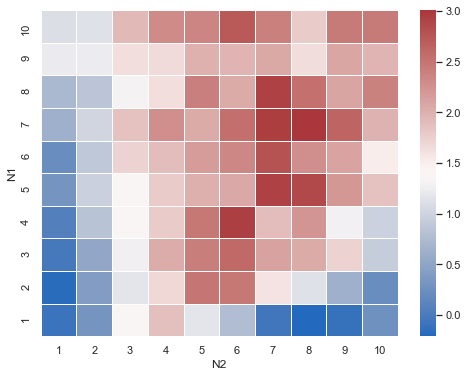

In [96]:
show_heatmap_df = pd.pivot_table(res_df, index='N1', columns='N2', values='cumu_r')

plt.figure(figsize=(8,6))
ax = sns.heatmap(show_heatmap_df[::-1], linewidths=.5, cmap="vlag")
plt.show()

In [97]:
import numpy as np
import pandas as pd
import pyecharts.options as opts
from pyecharts.charts import Surface3D

"""
Gallery 使用 pyecharts 1.1.0
参考地址: https://echarts.apache.org/examples/editor.html?c=surface-wave&gl=1

目前无法实现的功能:

1、暂时无法设置光滑表面 wireframe
2、暂时无法把 visualmap 进行隐藏
"""

show_df = res_df[['N2', 'N1', 'cumu_r']].sort_values(['N1', 'N2'], ascending=True)
surface_data=[row.tolist() for i,row in show_df.iterrows() ]

# 截止到上一行，由于3D曲面需要传入二维数组类型的数据，因此首先创建数据，
# 在此遇到一个问题，如果在第一个循环时我先把i赋值给x，第二个循环j赋值给y，则图形不会出现,我
# 对此类情况的想法是在绘制3d曲面的时候必须先进行x轴方向的变化才符合绘制规则
surface_3d=(
    Surface3D(init_opts=opts.InitOpts(width="800px",height="500px"))
    .add(
        series_name="cumu_r与N1,N2关系",
        data=surface_data,
        xaxis3d_opts=opts.Axis3DOpts(type_="value", name='N2\n(买入/卖出计数确认信号期数)'),
        yaxis3d_opts=opts.Axis3DOpts(type_="value", name='N1\n(买入/卖出启动进入计数期数)'),
        grid3d_opts=opts.Grid3DOpts(width=100, height=30, depth=100),
    )
    .set_global_opts(
        visualmap_opts=opts.VisualMapOpts(
            dimension=2,
            max_=3.1,
            min_=-0.1,
            range_color=['blue', 'green', 'yellow', 'red'],
        )        
    )
    
)
surface_3d.render_notebook()

## 拓展研究 - 整个历史样本调优

### 上证指数

#### 参数调优

In [104]:
""" 
    生成调优参数范围：
        N1 (1~10) 
        N2 (1~10)
        N3~(1~10)
"""        

n1_min, n1_max, n1_dist = 2, 10, 1
n2_min, n2_max, n2_dist = 2, 10, 1
n3_min, n3_max, n3_dist = 2, 10, 1

params = []
for i, n1 in enumerate(range(n1_min, n1_max+1, n1_dist)):
    for j, n2 in enumerate(range(n2_min, n2_max+1, n2_dist)):
        for k, n3 in enumerate(range(n3_min, n3_max+1, n3_dist)):
            params.append((n1, n2, n3))            

""" 选定回测数据范围 """
bt_data = daily_001.copy()

""" 开始滚动计算 """
# 1. q_buy_cne, q_sell_cnt只需计算一次
bt_data = calc_q_buysell_cnt(bt_data)

# 2. ud对不同n1才不一样, 提前算好存到一个dict里
bt_data_with_indi_dict = {n1: calc_ud(bt_data, n1=n1).copy()  
                          for n1 in range(n1_min, n1_max+1, n1_dist)}
# 3. 滚动起来
res_dfs = []
for p in tqdm(params):
    n1, n2, n3 = p[0], p[1], p[2]
    """ 样本期内评估表现 """
    bt_data_with_indi = bt_data_with_indi_dict[n1]
    _, perf_df = calc_cumu_hold_nv_and_position(bt_data_with_indi,
                                                calc_signal,    {'N2': n2, 'N3': n3},
                                                calc_sl_price,  None,
                                                calc_position,  {'shift_period': 1, 
                                                                 'otime_limit': None, 
                                                                 'etime_limit': None, 'is_daily_close': False,
                                                                 #'etime_limit': '15:00:00', 'is_daily_close': True,
                                                                 'is_consider_sl': True,
                                                                 'comm': 0.0002},
                                                statistic_performance, {'data_period': 1440,
                                                                        'is_consider_sl': True ,
                                                                        },
                                               )
    """ 记录【累计收益/最大回撤】 """
    annual_r_divide_max_dd = float(perf_df.values[16][0].strip('%'))/float(perf_df.values[14][0].strip('%'))
    cumu_r = float(perf_df.values[0][0].strip('%'))/100
    res_dfs.append([n1, n2, n3, annual_r_divide_max_dd, cumu_r])

res_df = pd.DataFrame(res_dfs, columns=['N1', 'N2', 'N3', 'annual_ret/max_dd', 'cumu_r'])

#print(res_df.sort_values('cumu_r', ascending=False).head(10).mean())
res_df.sort_values('annual_ret/max_dd', ascending=False).head(10)

100%|████████████████████████████████████████████████████████████████████████████████| 729/729 [00:27<00:00, 26.42it/s]


,N1,N2,N3,annual_ret/max_dd,cumu_r
575,9,2,10,0.562726,17.5719
416,7,3,4,0.504144,15.0235
521,8,5,10,0.500690,16.2001
107,3,4,10,0.483269,18.2843
574,9,2,9,0.482046,15.2050
263,5,4,4,0.446429,15.2954
245,5,2,4,0.415133,12.0704
488,8,2,4,0.390570,10.6989
407,7,2,4,0.382127,11.5269
118,3,6,3,0.381850,10.1947


#### 回测表现

In [106]:
daily_001 = calc_ud(daily_001, n1=9)
daily_001 = calc_q_buysell_cnt(daily_001)
daily_001 = calc_signal(daily_001, N2=2, N3=10)
daily_001 = calc_sl_price(daily_001)

print(daily_001['signal'].value_counts())

""" 持仓计算 """
daily_001 = calc_position(daily_001, shift_period=1, otime_limit=None, etime_limit=None, 
                           is_consider_open=True, is_consider_sl=True, is_daily_close=False,
                           comm=0.0002, 
                           leverage=None)


""" 策略评估 """
res_daily_001, performance_df = statistic_performance( daily_001,
                                                       r0=0.03, 
                                                       data_period=1440,
                                                       is_consider_sl=True, 
                                                      )

print(performance_df)
visualize_performance(res_daily_001)

 1.0    26
-1.0    23
Name: signal, dtype: int64
                  0
累计收益       1757.19%
多仓次数              9
多仓成功次数            6
多仓胜率         66.67%
多仓平均持有期      225.67
多仓止损次数            7
多仓止损率        77.78%
空仓次数              8
空仓成功次数            5
空仓胜率         62.50%
空仓平均持有期      212.25
空仓止损次数            3
空仓止损率        37.50%
周期胜率         54.22%
最大回撤         33.16%
年化收益/最大回撤      0.56
年化收益         18.66%
年化标准差        23.31%
年化夏普           0.80


### 沪深300期货m1

#### 参数调优

In [108]:
""" 
    生成调优参数范围：
        N1 (1~10) 
        N2 (1~10)
        N3~(1~10)
"""        

n1_min, n1_max, n1_dist = 2, 10, 1
n2_min, n2_max, n2_dist = 2, 10, 1
n3 = 10

params = []
for i, n1 in enumerate(range(n1_min, n1_max+1, n1_dist)):
    for j, n2 in enumerate(range(n2_min, n2_max+1, n2_dist)):
        params.append((n1, n2, n3))            

""" 选定回测数据范围 """
bt_data = m1_300.copy()

""" 开始滚动计算 """
# 1. q_buy_cne, q_sell_cnt只需计算一次
bt_data = calc_q_buysell_cnt(bt_data)

# 2. ud对不同n1才不一样, 提前算好存到一个dict里
bt_data_with_indi_dict = {n1: calc_ud(bt_data, n1=n1).copy()  
                          for n1 in range(n1_min, n1_max+1, n1_dist)}
# 3. 滚动起来
res_dfs = []
for p in tqdm(params):
    n1, n2, n3 = p[0], p[1], p[2]
    """ 样本期内评估表现 """
    bt_data_with_indi = bt_data_with_indi_dict[n1]
    _, perf_df = calc_cumu_hold_nv_and_position(bt_data_with_indi,
                                                calc_signal,    {'N2': n2, 'N3': n3},
                                                calc_sl_price,  None,
                                                calc_position,  {'shift_period': 1, 
                                                                 'otime_limit': None, 
                                                                 'etime_limit': None, 'is_daily_close': False,
                                                                 #'etime_limit': '15:00:00', 'is_daily_close': True,
                                                                 'is_consider_sl': True,
                                                                 'comm': 0.0002},
                                                statistic_performance, {'data_period': 1,
                                                                        'is_consider_sl': True ,
                                                                        },
                                               )
    """ 记录【累计收益/最大回撤】 """
    annual_r_divide_max_dd = float(perf_df.values[16][0].strip('%'))/float(perf_df.values[14][0].strip('%'))
    cumu_r = float(perf_df.values[0][0].strip('%'))/100
    res_dfs.append([n1, n2, n3, annual_r_divide_max_dd, cumu_r])

res_df = pd.DataFrame(res_dfs, columns=['N1', 'N2', 'N3', 'annual_ret/max_dd', 'cumu_r'])

#print(res_df.sort_values('cumu_r', ascending=False).head(10).mean())
res_df.sort_values('annual_ret/max_dd', ascending=False).head(10)

100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [03:33<00:00,  2.64s/it]


,N1,N2,N3,annual_ret/max_dd,cumu_r
18,4,2,10,0.863792,5.7847
10,3,3,10,0.837746,7.2700
19,4,3,10,0.826874,7.2845
54,8,2,10,0.756000,6.7032
45,7,2,10,0.709996,5.5394
55,8,3,10,0.694196,5.9159
27,5,2,10,0.683554,5.7243
46,7,3,10,0.646268,6.2337
9,3,2,10,0.640631,4.8984
63,9,2,10,0.631756,6.6446


#### 回测表现

In [112]:
""" 计算指标、信号、持仓 """
m1_300 = calc_ud(m1_300, n1=4)
m1_300 = calc_q_buysell_cnt(m1_300)
m1_300 = calc_signal(m1_300, N2=2, N3=10)
m1_300 = calc_sl_price(m1_300)
m1_300 = calc_position(m1_300, shift_period=1, otime_limit=None, 
                       etime_limit=None, is_daily_close=False,
                       is_consider_open=True, is_consider_sl=True, 
                       comm=0.0002, leverage=None)

print(m1_300['signal'].value_counts())

res_m1_300, performance_df = statistic_performance(m1_300, #m1_300[m1_300['date']<='2012-07-06'],
                                                   #m1_300[m1_300['date']>'2012-07-06'],
                                                   r0=0.03, 
                                                   data_period=1, 
                                                   is_consider_sl=True, 
                                                  )

print(performance_df)
#visualize_performance(res_m1_300)

-1.0    1925
 1.0    1055
Name: signal, dtype: int64
                 0
累计收益       578.47%
多仓次数           737
多仓成功次数         274
多仓胜率        37.18%
多仓平均持有期     246.61
多仓止损次数         363
多仓止损率       49.25%
空仓次数          1179
空仓成功次数         381
空仓胜率        32.32%
空仓平均持有期     231.78
空仓止损次数         926
空仓止损率       78.54%
周期胜率        50.27%
最大回撤        20.41%
年化收益/最大回撤     0.86
年化收益        17.63%
年化标准差       18.06%
年化夏普          0.98
